# **Fine Tuning Llama-2 using Google Colab**

## **Install Ludwig and Ludwig's LLM related dependencies.**

In [ ]:
!pip install ludwig
!pip install ludwig[llm]

In [ ]:
!pip uninstall -y tensorflow --quiet
!pip install pandas
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install "git+https://github.com/ludwig-ai/ludwig.git@master#egg=ludwig[llm]" --quiet

## **For emptying the cache**

In [3]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)

def clear_cache():
  if torch.cuda.is_available():
    torch.cuda.empty_cache()

## **Setting up the access for the model using Hugging face token**

In [4]:
import getpass
import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


## **Setting up and Reading the dataset**

In [5]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)
import pandas as pd

df = pd.read_json("/content/alpaca_data.json")


total_rows = len(df)
split_0_count = int(total_rows * 0.9)
split_1_count = int(total_rows * 0.05)
split_2_count = total_rows - split_0_count - split_1_count

# Create an array with split values based on the counts
split_values = np.concatenate([
    np.zeros(split_0_count),
    np.ones(split_1_count),
    np.full(split_2_count, 2)
])

# Shuffle the array to ensure randomness
np.random.shuffle(split_values)

# Add the 'split' column to the DataFrame
df['split'] = split_values
df['split'] = df['split'].astype(int)

# For this webinar, we will just 500 rows of this dataset.
df = df.head(n=500)

## **Printing the head of the dataset to check:**

In [6]:
df.head()

,instruction,input,output,split
0,Give three tips for staying healthy.,,1.Eat a balanced diet and make sure to include...,0
1,What are the three primary colors?,,"The three primary colors are red, blue, and ye...",0
2,Describe the structure of an atom.,,"An atom is made up of a nucleus, which contain...",0
3,How can we reduce air pollution?,,There are a number of ways to reduce air pollu...,2
4,Describe a time when you had to make a difficu...,,I had to make a difficult decision when I was ...,0


## **Counting the self-sufficient and additional context examples**

In [7]:
num_self_sufficient = (df['input'] == "").sum()
num_need_contex = df.shape[0] - num_self_sufficient

# We are only using 100 rows of this dataset for this webinar
print(f"Total number of examples in the dataset: {df.shape[0]}")

print(f"% of examples that are self-sufficient: {round(num_self_sufficient/df.shape[0] * 100, 2)}")
print(f"% of examples that are need additional context: {round(num_need_contex/df.shape[0] * 100, 2)}")

Total number of examples in the dataset: 500
% of examples that are self-sufficient: 54.4
% of examples that are need additional context: 45.6


## **Calculating length and average of each cell in each column and their distributions**

Average number of tokens in the instruction column: 17
Average number of tokens in the input column: 8
Average number of tokens in the output column: 82



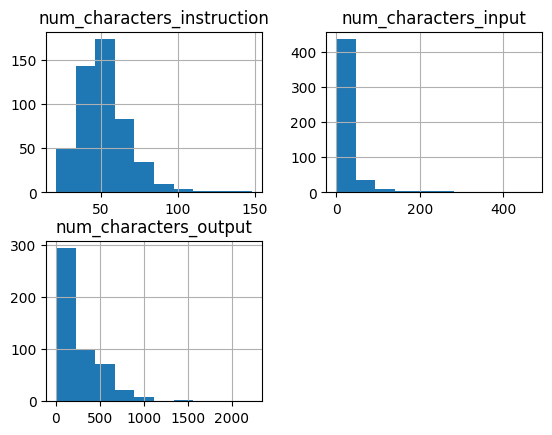

In [8]:
# Calculating the length of each cell in each column
df['num_characters_instruction'] = df['instruction'].apply(lambda x: len(x))
import pandas as pd

# Assuming 'df' is your DataFrame
df['num_characters_input'] = df['input'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)

df['num_characters_output'] = df['output'].apply(lambda x: len(str(x)) if not pd.isna(x) else 0)

# Show Distribution
df.hist(column=['num_characters_instruction', 'num_characters_input', 'num_characters_output'])

# Calculating the average
average_chars_instruction = df['num_characters_instruction'].mean()
average_chars_input = df['num_characters_input'].mean()
average_chars_output = df['num_characters_output'].mean()

print(f'Average number of tokens in the instruction column: {(average_chars_instruction / 3):.0f}')
print(f'Average number of tokens in the input column: {(average_chars_input / 3):.0f}')
print(f'Average number of tokens in the output column: {(average_chars_output / 3):.0f}', end="\n\n")

## **Fine tuning of the model**

In [ ]:
zero_shot_config = yaml.safe_load(
  """
  model_type: llm
  base_model: meta-llama/Llama-2-7b-hf

  input_features:
    - name: input
      type: text

  output_features:
    - name: output
      type: text

  prompt:
    template: >-
      Below is an instruction that describes a task, paired with an input
      that may provide further context. Write a response that appropriately
      completes the request.

      ### Instruction: {instruction}

      ### Input: {input}

      ### Response:

  generation:
    temperature: 0.1 # Temperature is used to control the randomness of predictions.
    max_new_tokens: 512

  preprocessing:
    split:
      type: fixed

  quantization:
    bits: 4
  """
)

model = LudwigModel(config=zero_shot_config, logging_level=logging.INFO)
results = model.train(dataset=df)

## **Fine tuning using qlora (optional)**

In [ ]:
import torch
model = None  # Dereference the model
torch.cuda.empty_cache()  # Clear the GPU cache

qlora_fine_tuning_config = yaml.safe_load(
"""
model_type: llm
base_model: meta-llama/Llama-2-7b-hf

input_features:
  - name: instruction
    type: text

output_features:
  - name: output
    type: text

prompt:
  template: >-
    Below is an instruction that describes a task, paired with an input
    that provides further context. Write a response that appropriately
    completes the request.

    ### Instruction: {instruction}

    ### Input: {input}

    ### Response:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  global_max_sequence_length: 512

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 1
  gradient_accumulation_steps: 16
  learning_rate: 0.00001
  optimizer:
    type: adam
    params:
      eps: 1.e-8
      betas:
        - 0.9
        - 0.999
      weight_decay: 0
  learning_rate_scheduler:
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)

model = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)
results = model.train(dataset=df)

### **Test Examples to check how well the model has been fine tuned**

In [ ]:
test_examples = pd.DataFrame([
      {
            "instruction": "Create an array of length 5 which contains all even numbers between 1 and 10.",
            "input": "",
      },
      {
            "instruction": "Create an array of length 15 containing numbers divisible by 3 up to 45.",
            "input": "",
      },
      {
            "instruction": "Create a nested loop to print every combination of numbers between 0-9",
            "input": ""
      },
      {
            "instruction": "Generate a function that computes the sum of the numbers in a given list",
            "input": "",
      },
      {
            "instruction": "Create a class to store student names, ages and grades.",
            "input": "",
      },
      {
            "instruction": "Print out the values in the following dictionary.",
            "input": "my_dict = {\n  'name': 'John Doe',\n  'age': 32,\n  'city': 'New York'\n}",
      },
])

predictions = model.predict(test_examples)[0]
for input_with_prediction in zip(test_examples['instruction'], test_examples['input'], predictions['output_response']):
  print(f"Instruction: {input_with_prediction[0]}")
  print(f"Input: {input_with_prediction[1]}")
  print(f"Generated Output: {input_with_prediction[2][0]}")
  print("\n\n")